# Sprint 2: Schema Design

#### Initial configuration and conection to duckdb and ducklake

In [42]:
import duckdb
import pandas as pd
import os
import glob

# --- 1. Configuration & Paths ---
RAW_DATA_PATH = '../data/raw/'
LAKEHOUSE_PATH = '../data/lakehouse'
METADATA_PATH = os.path.join(LAKEHOUSE_PATH, 'metadata.duckdb')

# Create the base directory if it doesn't exist
os.makedirs(LAKEHOUSE_PATH, exist_ok=True)

# --- 2. Initialize DuckDB & Load DuckLake Extension ---
# Connect to in-memory DuckDB (Compute Layer)
con = duckdb.connect(database=':memory:')

print("--- Initializing DuckLake Extension ---")

# ✅ ACTIVATE DUCKLAKE: This downloads/installs the extension if missing
# and loads it into the current session.
try:
    con.execute("INSTALL ducklake;")
    con.execute("LOAD ducklake;")
    print("✅ Extension 'ducklake' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading 'ducklake'. Make sure the extension is available in your environment.\nError: {e}")

--- Initializing DuckLake Extension ---
✅ Extension 'ducklake' loaded successfully.


#### Attach the Catalog and Schema Management

In [43]:
# --- 3. Attach the Catalog ---
# We attach the persistent storage. 
# Note: Depending on your specific DuckLake version, the syntax for ATTACH might vary slightly.
# This assumes standard syntax where we point to the metadata file.
con.execute(f"ATTACH 'ducklake:{METADATA_PATH}' AS lakehouse")
print(f"✅ Lakehouse catalog attached at: {METADATA_PATH}")

# --- 4. Schema Management ---
# Create logical schemas within the managed catalog
schemas = ['bronze', 'silver', 'gold']
for schema in schemas:
    con.execute(f"CREATE SCHEMA IF NOT EXISTS lakehouse.{schema}")
print(f"✅ Schemas ready: {', '.join(schemas)}")

✅ Lakehouse catalog attached at: ../data/lakehouse\metadata.duckdb
✅ Schemas ready: bronze, silver, gold


---
# Bronze Layer

#### Inserting the data into the partitioned table

In [ ]:
import os
import glob
import time
import re

# --- Configuration ---
MITMA_PATH = os.path.join(RAW_DATA_PATH, 'mitma', '*_Viajes_municipios.csv.gz')
files = sorted(glob.glob(MITMA_PATH)) # Sort to process in order

print(f"\n--- 🔄 Batched Upsert Ingestion (Bronze) ---")
print(f"-> Found {len(files)} files to process.")

# 1. Ensure Table Exists (Empty Structure)
# We create it if it doesn't exist, using the first file to infer schema
if files:
    # Check if table exists
    table_check = con.execute("SELECT count(*) FROM information_schema.tables WHERE table_name = 'mobility_sample_week' AND table_schema = 'bronze'").fetchone()[0]
    
    if table_check == 0:
        print("-> Creating table structure...")
        con.execute(f"""
            CREATE TABLE lakehouse.bronze.mobility_sample_week AS 
            SELECT 
                *,
                CURRENT_TIMESTAMP AS ingestion_timestamp,
                'MITMA_URL' AS source_url
            FROM read_csv_auto('{files[0]}', filename=true, all_varchar=true)
            LIMIT 0;
        """)
        # Configure Partitioning immediately
        con.execute("ALTER TABLE lakehouse.bronze.mobility_sample_week SET PARTITIONED BY (fecha);")

# 2. Batch Processing Loop
total_start = time.time()

for i, file_path in enumerate(files):
    file_name = os.path.basename(file_path)
    loop_start = time.time()
    
    # --- A. Extract Date from Filename (Python side) ---
    # Assuming filename format: '20231003_Viajes_municipios.csv.gz'
    # We look for the first 8 digits
    match = re.search(r'(\d{8})', file_name)
    
    if match:
        date_str = match.group(1) # e.g., "20231003"
        
        try:
            # --- B. The "Upsert" (Delete existing partition first) ---
            # This ensures idempotency: if you run this script twice, you won't get duplicate data.
            con.execute(f"DELETE FROM lakehouse.bronze.mobility_sample_week WHERE fecha = '{date_str}'")
            
            # --- C. The Insert (With Error Handling) ---
            query_insert = f"""
                INSERT INTO lakehouse.bronze.mobility_sample_week 
                SELECT 
                    *,
                    CURRENT_TIMESTAMP AS ingestion_timestamp,
                    'https://www.transportes.gob.es/...' AS source_url
                FROM read_csv_auto(
                    '{file_path}', 
                    filename=true, 
                    all_varchar=true, 
                    ignore_errors=true  -- Handle corrupted rows
                );
            """
            con.execute(query_insert)
            
            elapsed = time.time() - loop_start
            print(f"[{i+1}/{len(files)}] ✅ Upserted {date_str} (File: {file_name}) in {elapsed:.2f}s")
            
        except Exception as e:
            print(f"[{i+1}/{len(files)}] ❌ Error processing {file_name}: {e}")
            
    else:
        print(f"[{i+1}/{len(files)}] ⚠️ Skipped {file_name} (Could not extract date)")

print(f"\n✨ Ingestion Complete in {(time.time() - total_start):.2f} seconds.")

# --- Validation ---
print("\n[Final Count]:")
con.execute("SELECT COUNT(*) FROM lakehouse.bronze.mobility_sample_week").df()


--- 🔄 Batched Upsert Ingestion (Bronze) ---
-> Found 27 files to process.
-> Creating table structure...
[1/27] ✅ Upserted 20231001 (File: 20231001_Viajes_municipios.csv.gz) in 4.87s
[2/27] ✅ Upserted 20231002 (File: 20231002_Viajes_municipios.csv.gz) in 5.15s
[3/27] ✅ Upserted 20231003 (File: 20231003_Viajes_municipios.csv.gz) in 5.58s
[4/27] ✅ Upserted 20231004 (File: 20231004_Viajes_municipios.csv.gz) in 6.00s
[5/27] ✅ Upserted 20231005 (File: 20231005_Viajes_municipios.csv.gz) in 6.17s
[6/27] ✅ Upserted 20231006 (File: 20231006_Viajes_municipios.csv.gz) in 5.96s
[7/27] ✅ Upserted 20231007 (File: 20231007_Viajes_municipios.csv.gz) in 5.91s
[8/27] ✅ Upserted 20231008 (File: 20231008_Viajes_municipios.csv.gz) in 6.48s
[9/27] ✅ Upserted 20231009 (File: 20231009_Viajes_municipios.csv.gz) in 6.75s
[10/27] ✅ Upserted 20231010 (File: 20231010_Viajes_municipios.csv.gz) in 7.36s
[11/27] ✅ Upserted 20231011 (File: 20231011_Viajes_municipios.csv.gz) in 8.64s
[12/27] ✅ Upserted 20231012 (File:

#### Data and Schema Preview of Mobility Files

In [ ]:
# --- INSPECTION & METADATA CHECK ---
print("\n--- 🔍 INSPECTION: Mobility Table ---")

# 1. Content Preview
# Verify that 'origen' and 'destino' columns look like municipal codes (5 digits)
print("\n[1] Data Preview (First 5 rows):")
con.execute("SELECT * FROM lakehouse.bronze.mobility_sample_week  LIMIT 5").df()

In [ ]:
# 2. Schema Check
# Confirm column names and ensure types are currently VARCHAR (as expected for Bronze)
print("\n[2] Schema (Columns & Types):")
con.execute("DESCRIBE lakehouse.bronze.mobility_sample_week ").df()

In [ ]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute("SUMMARIZE lakehouse.bronze.mobility_sample_week ").df()

### Ingesting other tables

In [3]:
# --- 6. Ingestion: Auxiliary Tables (Refactorizado con Linaje) ---

# Define URLs 
URL_MITMA = "https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad"
URL_INE = "https://www.ine.es/"
URL_CNIG = "https://centrodedescargas.cnig.es/CentroDescargas/index.jsp"
URL_MTDFP = "https://datos.gob.es/es/catalogo/l01280796-calendario-laboral"

def ingest_dimension(table_name, filename, source_url, folder='mitma', sep=';', encoding='utf-8', **kwargs):
    path = os.path.join(RAW_DATA_PATH, folder, filename)
    
    if os.path.exists(path):
        # Escape single quotes in the URL for SQL safety
        safe_url = source_url.replace("'", "''")

        options = f"filename=true, all_varchar=true, sep='{sep}', encoding='{encoding}'"

        for key, value in kwargs.items():
            # Handle boolean SQL syntax (true/false instead of True/False)
            if isinstance(value, bool):
                sql_val = str(value).lower()
            else:
                sql_val = f"'{value}'"
            options += f", {key}={sql_val}"
            
        print(f"-> Ingesting {table_name} with options: [{options}]")
        
        # Read the CSV and append audit columns
        # We use robust typing (try_cast/all_varchar) to prevent failures if any numeric column contains irregular characters
        con.execute(f"""
            CREATE OR REPLACE TABLE lakehouse.bronze.{table_name} AS
            SELECT 
                *,
                CURRENT_TIMESTAMP AS ingestion_timestamp,
                '{safe_url}' AS source_url
            FROM read_csv_auto('{path}', {options});
        """)
        print(f"✅ Ingested: lakehouse.bronze.{table_name} (Source: {source_url})")
    else:
        print(f"⚠️ Missing file: {filename}")

print("\n--- Ingesting Dictionaries & Dimensions ---")

# 1. Nombres de Distritos (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('zoning_municipalities', 'nombres_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|', header=True)

# 2. Población por Distrito (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('population_municipalities', 'poblacion_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 3. Relación Zonificación MITMA <-> INE
# Fuente: Open Data Movilidad
ingest_dimension('mapping_ine_mitma', 'relacion_ine_zonificacionMitma.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 4. Renta Media (INE)
# Fuente: Instituto Nacional de Estadística
ingest_dimension('ine_rent_municipalities', 'ine_renta.csv', source_url=URL_INE, folder='ine', sep=';')

# 5. Coordenadas Municipales (IGN/CNIG)
# Fuente: Centro de Descargas del CNIG
ingest_dimension('municipal_coordinates', 'municipios_coordenadas.csv', source_url=URL_CNIG, folder='ine', sep=';')

# 6. Calendarios Laborales (MTDFP)
# Fuente: Centro de Descargas del MTDFP
ingest_dimension('work_calendars', 'calendario.csv', source_url=URL_MTDFP, folder='ine', sep=';')


--- Ingesting Dictionaries & Dimensions ---
-> Ingesting zoning_municipalities with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8', header=true]
✅ Ingested: lakehouse.bronze.zoning_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting population_municipalities with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.population_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting mapping_ine_mitma with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.mapping_ine_mitma (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting ine_rent_municipalities with options: [filename=true, all_varchar

#### Inspection: mapping_ine_mitma

In [ ]:
# Define the table we want to inspect
target_table = "lakehouse.bronze.mapping_ine_mitma"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} WHERE municipio_ine LIKE 'NA' LIMIT 5").df()

In [ ]:
# 2. Schema Metadata (Structure)
# Shows column names and types. Since we used 'all_varchar=true', everything should be VARCHAR.
print("\n[2] Schema Metadata (Columns & Types):")
con.execute(f"DESCRIBE {target_table}").df()

In [ ]:
# 3. Quality Profile (Statistics)
# Check 'approx_unique' to see how many municipalities have data
# Check 'null_percentage' to ensure the ingestion didn't fail silently
print("\n[3] Quality Statistics (Nulls & Uniques):")
con.execute(f"SUMMARIZE {target_table}").df()

#### Final Check: table names and schema name

In [ ]:
# --- 7. Final Check ---
print("\n--- Current Lakehouse State (Bronze Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'bronze';
"""
df_result = con.execute(query_check).df()
print(df_result)

---
# Silver Layer

### Zone table

In [4]:
# Check column names to ensure our JOIN uses the right keys
print("--- Checking Columns ---")
print("Zones (MITMA):", con.execute("DESCRIBE lakehouse.bronze.zoning_municipalities").fetch_df()['column_name'].tolist())
print("Mapping (INE):", con.execute("DESCRIBE lakehouse.bronze.work_calendars").fetch_df()['column_name'].tolist())

--- Checking Columns ---
Zones (MITMA): ['column0', 'ID', 'name', 'filename', 'ingestion_timestamp', 'source_url']
Mapping (INE): ['Dia', 'Dia_semana', 'laborable / festivo / domingo festivo', 'Tipo de Festivo', 'Festividad', 'column5', 'column6', 'column7', 'column8', 'filename', 'ingestion_timestamp', 'source_url']


In [5]:
print("\n--- Building Silver Table: dim_zones ---")

query_dim_zones = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.dim_zones AS
    WITH unique_mapping AS (
        -- CRITICAL CHANGE: We GROUP BY the MITMA code.
        -- We take the FIRST (Minimum) INE code found as the 'Representative' code.
        -- This ensures 1 MITMA Zone = 1 Row.
        SELECT DISTINCT 
            CAST(municipio_mitma AS VARCHAR) as mitma_ref,
            MIN(CAST(municipio_ine AS VARCHAR)) as ine_ref
        FROM lakehouse.bronze.mapping_ine_mitma
        WHERE municipio_mitma IS NOT NULL
            AND municipio_ine IS NOT NULL
            AND municipio_ine NOT LIKE 'NA'
            AND municipio_mitma NOT LIKE 'NA'
        GROUP BY municipio_mitma
    ),
    raw_zones AS (
        SELECT 
            TRIM(z.ID) AS mitma_code,
            TRIM(m.ine_ref)  AS ine_code,
            TRIM(z.name) AS zone_name
        FROM lakehouse.bronze.zoning_municipalities z
        INNER JOIN unique_mapping m 
            ON TRIM(z.ID) = TRIM(m.mitma_ref)
        WHERE z.ID IS NOT NULL AND z.ID != 'ID'
        GROUP BY z.ID, z.name, m.ine_ref
    )
    SELECT
        -- 1. Codes
        ROW_NUMBER() OVER (ORDER BY mitma_code) AS zone_id,
        mitma_code,
        ine_code,
        zone_name,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM raw_zones
    ORDER BY zone_id;
"""
con.execute(query_dim_zones)
print("✅ Created: lakehouse.silver.dim_zones")


--- Building Silver Table: dim_zones ---
✅ Created: lakehouse.silver.dim_zones


In [6]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_zones"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()



--- 🔍 INSPECTING: lakehouse.silver.dim_zones ---

[1] Content Preview (First 5 rows):


,zone_id,mitma_code,ine_code,zone_name,processed_at
0,1,01001,01001,Alegría-Dulantzi,2025-12-04 12:04:16.724440+01:00
1,2,01002,01002,Amurrio,2025-12-04 12:04:16.724440+01:00
2,3,01004_AM,01004,Artziniega agregacion de municipios,2025-12-04 12:04:16.724440+01:00
3,4,01009_AM,01009,Asparrena agregacion de municipios,2025-12-04 12:04:16.724440+01:00
4,5,01010,01010,Ayala/Aiara,2025-12-04 12:04:16.724440+01:00


In [7]:
# Check coverage
total = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones").fetchone()[0]
mapped = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NOT NULL").fetchone()[0]
print(f"-> Statistics: {mapped}/{total} zones have been successfully mapped to INE codes.")

-> Statistics: 2569/2569 zones have been successfully mapped to INE codes.


In [8]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.75074429802,643,1285,1927,2569,0.0
1,mitma_code,VARCHAR,01001,52001,2239,None,None,None,None,None,2569,0.0
2,ine_code,VARCHAR,01001,52001,2078,None,None,None,None,None,2569,0.0
3,zone_name,VARCHAR,Abadiño agregacion de municipios,Úbeda,2414,None,None,None,None,None,2569,0.0
4,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-04 12:04:16.72444+01,2025-12-04 12:04:16.72444+01,1,2025-12-04 12:04:16.72444+01,None,2025-12-04 12:04:16.72444+01,2025-12-04 12:04:16.72444+01,2025-12-04 12:04:16.72444+01,2569,0.0


### Population table

In [9]:
print("\n--- Building Silver Table: metric_population ---")

query_pop = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_population AS
    SELECT 
        -- 1. Linking Key (Map column0 -> zone_id)
        z.zone_id,
        
        -- 2. The Metric (Map column1 -> population)
        -- Logic:
        --   a. Cast to Integer
        CAST(TRY_CAST(column1 AS DOUBLE) AS BIGINT) AS population,
        
        -- 3. Metadata
        2023 AS year,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.population_municipalities p
        JOIN lakehouse.silver.dim_zones z ON TRIM(p.column0) = z.mitma_code
    
    WHERE 
        -- Filter out empty rows
        column0 IS NOT NULL 
        -- Filter out the header row (if the first row contains text like 'ID' or 'Poblacion')
        AND NOT regexp_matches(column1, '[a-zA-Z]') -- Exclude rows where population contains letters
"""
con.execute(query_pop)
print("✅ Created: lakehouse.silver.metric_population")


--- Building Silver Table: metric_population ---
✅ Created: lakehouse.silver.metric_population


In [10]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_population"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_population ---

[1] Content Preview (First 5 rows):


,zone_id,population,year,processed_at
0,1,2925,2023,2025-12-04 12:04:20.987983+01:00
1,2,10307,2023,2025-12-04 12:04:20.987983+01:00
2,3,3005,2023,2025-12-04 12:04:20.987983+01:00
3,4,4599,2023,2025-12-04 12:04:20.987983+01:00
4,5,2951,2023,2025-12-04 12:04:20.987983+01:00


In [11]:
stats = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(population) as total_population_spain
    FROM lakehouse.silver.metric_population
""").fetchone()
print(f"-> Integrity Check: {stats[0]} rows loaded. Total Population: {stats[1]:,}")

-> Integrity Check: 2569 rows loaded. Total Population: 47,385,107


In [12]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.75074429802,643,1285,1927,2569,0.0
1,population,BIGINT,1504,3305408,2506,18444.961852861037,83792.93419494132,4583,5988,12307,2569,0.0
2,year,INTEGER,2023,2023,1,2023.0,0.0,2023,2023,2023,2569,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-04 12:04:20.987983+01,2025-12-04 12:04:20.987983+01,1,2025-12-04 12:04:20.987983+01,None,2025-12-04 12:04:20.987983+01,2025-12-04 12:04:20.987983+01,2025-12-04 12:04:20.987983+01,2569,0.0


### Coordinates table

In [13]:
print("\n--- Building Silver Table: dim_coordinates ---")

query_coords = """
    CREATE OR REPLACE TABLE lakehouse.silver.dim_coordinates AS
    SELECT 
        z.zone_id,
        
        -- Coordinates
        TRY_CAST(REPLACE(c.LATITUD_ETRS89, ',', '.') AS DOUBLE) AS latitude,
        TRY_CAST(REPLACE(c.LONGITUD_ETRS89, ',', '.') AS DOUBLE) AS longitude,
        
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.municipal_coordinates c
    
    -- SIMPLE JOIN: Exact string match
    JOIN lakehouse.silver.dim_zones z 
        ON LEFT(c.COD_INE, 5) = z.ine_code 
        
    WHERE z.zone_id IS NOT NULL
        AND TRY_CAST(REPLACE(c.LATITUD_ETRS89, ',', '.') AS DOUBLE) IS NOT NULL
        AND TRY_CAST(REPLACE(c.LONGITUD_ETRS89, ',', '.') AS DOUBLE) IS NOT NULL;
"""

con.execute(query_coords)
print("✅ Created: lakehouse.silver.dim_coordinates")


--- Building Silver Table: dim_coordinates ---
✅ Created: lakehouse.silver.dim_coordinates


In [14]:
# --- CRITICAL CHECK ---
# Let's see if the "Simple Join" worked or if we lost data due to "01001" vs "1001"
total_zones_with_ine = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NOT NULL").fetchone()[0]
matched_coords = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_coordinates").fetchone()[0]

print(f"\n[Match Statistics]")
print(f"Zones with INE Codes: {total_zones_with_ine}")
print(f"Zones with Coordinates: {matched_coords}")

if matched_coords < (total_zones_with_ine * 0.5):
    print("⚠️ WARNING: Very low match rate. It is highly likely one table has leading zeros ('01001') and the other does not ('1001').")


[Match Statistics]
Zones with INE Codes: 2569
Zones with Coordinates: 2569


In [15]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_coordinates"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.dim_coordinates ---

[1] Content Preview (First 5 rows):


,zone_id,latitude,longitude,processed_at
0,1,42.839812,-2.512437,2025-12-04 12:04:21.226214+01:00
1,2,43.054278,-3.000073,2025-12-04 12:04:21.226214+01:00
2,13,43.051197,-2.565400,2025-12-04 12:04:21.226214+01:00
3,3,43.120844,-3.127917,2025-12-04 12:04:21.226214+01:00
4,10,42.723262,-2.871835,2025-12-04 12:04:21.226214+01:00


In [16]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.7507442980203,643,1285,1927,2569,0.0
1,latitude,DOUBLE,27.75610338,43.7362013,2354,40.0202751762165,2.9007280340721717,38.472583702976195,40.459417474172874,42.05649168576426,2569,0.0
2,longitude,DOUBLE,-17.99838148,4.28966629,2286,-3.2713909810797945,3.851965119360112,-5.482810623645237,-3.4119487497700676,-0.5323519930910949,2569,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-04 12:04:21.226214+01,2025-12-04 12:04:21.226214+01,1,2025-12-04 12:04:21.226214+01,None,2025-12-04 12:04:21.226214+01,2025-12-04 12:04:21.226214+01,2025-12-04 12:04:21.226214+01,2569,0.0


### Rent table

In [17]:
print("\n--- Building Silver Table: metric_ine_rent ---")

query_rent = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_ine_rent AS
    SELECT 
        -- 1. Master Key (Zone ID from our Dimension)
        z.zone_id,
        
        -- 2. The Metric (Cleaned)
        -- Format: "13.500" -> 13500. Handle "dirty" data (like ".") using TRY_CAST
        TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) AS income_per_capita,
        
        -- 3. Time Reference
        CAST(r.Periodo AS INTEGER) AS year,
        
        -- 4. Metadata
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.ine_rent_municipalities r
    
    -- JOIN Logic: Match Extracted INE Code to Zone INE Code
    -- We split "01001 Name" by space to get "01001"
    JOIN lakehouse.silver.dim_zones z 
        ON split_part(r.Municipios, ' ', 1) = z.ine_code
        
    WHERE 
        -- Filter 1: Only the specific indicator requested
        r."Indicadores de renta media" = 'Renta neta media por persona'
        
        -- Filter 2: Ensure we are at Municipality level (Districts/Sections must be empty/null)
        AND (r.Distritos IS NULL OR r.Distritos = '')
        AND (r.Secciones IS NULL OR r.Secciones = '')
        
        -- Filter 3: Valid data
        AND TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) IS NOT NULL
        AND z.zone_id IS NOT NULL;
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.metric_ine_rent")


--- Building Silver Table: metric_ine_rent ---
✅ Created: lakehouse.silver.metric_ine_rent


In [18]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Available Years::")
con.execute(f"SELECT year, COUNT(*) as zones FROM lakehouse.silver.metric_ine_rent GROUP BY year").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Available Years::


,year,zones
0,2015,2472
1,2016,2517
2,2017,2492
3,2018,2496
4,2019,2493
5,2020,2569
6,2021,2569
7,2022,2566
8,2023,2565


In [19]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} ORDER BY zone_id LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Content Preview (First 5 rows):


,zone_id,income_per_capita,year,processed_at
0,1,16429.0,2023,2025-12-04 12:04:21.411453+01:00
1,1,15116.0,2022,2025-12-04 12:04:21.411453+01:00
2,1,14647.0,2021,2025-12-04 12:04:21.411453+01:00
3,1,13969.0,2020,2025-12-04 12:04:21.411453+01:00
4,1,14299.0,2019,2025-12-04 12:04:21.411453+01:00


In [20]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1281.4403887594,743.1254189209327,637,1279,1920,22739,0.0
1,income_per_capita,DOUBLE,5296.0,30682.0,8418,11553.643915739478,2746.345089655098,9533.527928520918,11217.585808015872,13193.86275942567,22739,0.0
2,year,INTEGER,2015,2023,10,2019.0328070715511,2.582302791867128,2017,2019,2021,22739,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-04 12:04:21.411453+01,2025-12-04 12:04:21.411453+01,1,2025-12-04 12:04:21.411453+01,None,2025-12-04 12:04:21.411453+01,2025-12-04 12:04:21.411453+01,2025-12-04 12:04:21.411453+01,22739,0.0


### Mobility data table

In [21]:
import time

print("\n--- 🏗️ Building Silver Fact Table (Batched & Idempotent) ---")

# 1. Setup: Ensure Table Exists (Only create if missing or if you want a full reset)
# Note: For this script, I'll drop it to ensure you start with a clean schema matching your code
con.execute("DROP TABLE IF EXISTS lakehouse.silver.fact_mobility")

con.execute("""
    CREATE TABLE IF NOT EXISTS lakehouse.silver.fact_mobility (
        date DATE,
        hour INTEGER,
        origin_zone_id BIGINT,
        destination_zone_id BIGINT,
        trips DOUBLE,
        processed_at TIMESTAMP
    );
""")

# 2. Configure Partitioning
# This only needs to run once when the table is created
try:
    con.execute("ALTER TABLE lakehouse.silver.fact_mobility SET PARTITIONED BY (date);")
except:
    pass # Already partitioned

# 3. Strategy: Get list of Days from Bronze
# We read the bronze partitions to know what work we have to do
print("-> Scanning Bronze partitions...")
dates_df = con.execute("""
    SELECT DISTINCT fecha 
    FROM lakehouse.bronze.mobility_sample_week 
    WHERE try_strptime(fecha, '%Y%m%d') IS NOT NULL
    ORDER BY fecha
""").df()

dates_list = dates_df['fecha'].tolist()
print(f"-> Found {len(dates_list)} days to process.")

# 4. Processing Loop
total_start = time.time()

for i, raw_date_str in enumerate(dates_list):
    loop_start = time.time()
    
    # Logic to format the date string (20230101) into a SQL Date ('2023-01-01') for the DELETE logic
    # We let DuckDB handle the casting in the query parameters
    
    try:
        # A. IDEMPOTENCY: Delete existing data for this specific date
        # If we are re-running, this prevents duplicates.
        con.execute(f"DELETE FROM lakehouse.silver.fact_mobility WHERE date = strptime('{raw_date_str}', '%Y%m%d')")
        
        # B. INSERT: Process only the specific bronze partition
        query_batch = f"""
            INSERT INTO lakehouse.silver.fact_mobility
            SELECT 
                try_strptime(m.fecha, '%Y%m%d') AS date,
                CAST(m.periodo AS INTEGER) AS hour,
                zo.zone_id AS origin_zone_id,
                zd.zone_id AS destination_zone_id,
                
                -- Cleaning Metrics
                TRY_CAST(REPLACE(REPLACE(m.viajes, '.', ''), ',', '.') AS DOUBLE) AS trips,
                
                CURRENT_TIMESTAMP AS processed_at
                
            FROM lakehouse.bronze.mobility_sample_week m
            INNER JOIN lakehouse.silver.dim_zones zo ON TRIM(m.origen) = zo.mitma_code
            INNER JOIN lakehouse.silver.dim_zones zd ON TRIM(m.destino) = zd.mitma_code

            WHERE 
                -- CRITICAL: Hit only the specific partition folder
                m.fecha = '{raw_date_str}' 
                AND m.viajes IS NOT NULL
                AND try_strptime(m.fecha, '%Y%m%d') IS NOT NULL;
        """
        con.execute(query_batch)
        
        elapsed = time.time() - loop_start
        print(f"[{i+1}/{len(dates_list)}] ✅ Processed {raw_date_str} in {elapsed:.2f}s")
        
    except Exception as e:
        print(f"❌ Error processing {raw_date_str}: {e}")

print(f"\n✨ Silver Transformation Complete in {(time.time() - total_start):.2f} seconds.")

# --- Validation ---
print("\n[Preview]:")
con.execute("SELECT * FROM lakehouse.silver.fact_mobility LIMIT 5").df()


--- 🏗️ Building Silver Fact Table (Batched & Idempotent) ---
-> Scanning Bronze partitions...
-> Found 24 days to process.
[1/24] ✅ Processed 20231001 in 0.82s
[2/24] ✅ Processed 20231002 in 0.83s
[3/24] ✅ Processed 20231003 in 0.90s
[4/24] ✅ Processed 20231004 in 0.94s
[5/24] ✅ Processed 20231005 in 1.00s
[6/24] ✅ Processed 20231006 in 0.79s
[7/24] ✅ Processed 20231007 in 0.80s
[8/24] ✅ Processed 20231008 in 0.95s
[9/24] ✅ Processed 20231009 in 1.10s
[10/24] ✅ Processed 20231010 in 0.91s
[11/24] ✅ Processed 20231011 in 1.12s
[12/24] ✅ Processed 20231012 in 0.86s
[13/24] ✅ Processed 20231013 in 1.23s
[14/24] ✅ Processed 20231014 in 0.98s
[15/24] ✅ Processed 20231015 in 0.94s
[16/24] ✅ Processed 20231016 in 0.92s
[17/24] ✅ Processed 20231017 in 1.20s
[18/24] ✅ Processed 20231018 in 0.93s
[19/24] ✅ Processed 20231019 in 0.87s
[20/24] ✅ Processed 20231020 in 1.09s
[21/24] ✅ Processed 20231021 in 1.07s
[22/24] ✅ Processed 20231022 in 0.81s
[23/24] ✅ Processed 20231023 in 0.89s
[24/24] ✅ P

,date,hour,origin_zone_id,destination_zone_id,trips,processed_at
0,2023-10-01,0,1,4,3056.0,2025-12-04 12:04:22.168263
1,2023-10-01,0,1,4,22.0,2025-12-04 12:04:22.168263
2,2023-10-01,0,1,4,9827.0,2025-12-04 12:04:22.168263
3,2023-10-01,0,1,11,3135.0,2025-12-04 12:04:22.168263
4,2023-10-01,0,1,11,2627.0,2025-12-04 12:04:22.168263


In [22]:
# Define the table we want to inspect
target_table = "lakehouse.silver.fact_mobility"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.fact_mobility ---

[1] Content Preview (First 5 rows):


,date,hour,origin_zone_id,destination_zone_id,trips,processed_at
0,2023-10-01,0,1,4,3056.0,2025-12-04 12:04:22.168263
1,2023-10-01,0,1,4,22.0,2025-12-04 12:04:22.168263
2,2023-10-01,0,1,4,9827.0,2025-12-04 12:04:22.168263
3,2023-10-01,0,1,11,3135.0,2025-12-04 12:04:22.168263
4,2023-10-01,0,1,11,2627.0,2025-12-04 12:04:22.168263


In [23]:
# --- QA: Referential Integrity Check ---
# Are there zones in our trips that don't exist in our dictionary?

print("--- 🔍 Checking for Orphan Keys ---")

query_orphans = """
    SELECT 
        m.origin_zone_id,
        COUNT(*) as trip_count
    FROM lakehouse.silver.fact_mobility m
    LEFT JOIN lakehouse.silver.dim_zones z 
        ON m.origin_zone_id = z.zone_id
    WHERE z.zone_id IS NULL
    GROUP BY m.origin_zone_id
    ORDER BY trip_count DESC
    LIMIT 10;
"""

orphans = con.execute(query_orphans).fetch_df()

if orphans.empty:
    print("✅ PERFECT: All origin zones in mobility data exist in dim_zones.")
else:
    print(f"⚠️ WARNING: Found {len(orphans)} zone IDs in mobility data that are MISSING from dim_zones.")
    print("Top missing zones (by trip volume):")
    print(orphans)

--- 🔍 Checking for Orphan Keys ---
✅ PERFECT: All origin zones in mobility data exist in dim_zones.


In [24]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,date,DATE,2023-10-01,2023-10-24,23,2023-10-12 18:29:49.282539,None,2023-10-07,2023-10-13,2023-10-19,270752721,0.0
1,hour,INTEGER,0,23,24,13.130267488613715,5.763992638856398,9,14,18,270752721,0.0
2,origin_zone_id,BIGINT,1,2569,2645,1250.0056526560263,757.849475956434,484,1372,1877,270752721,0.0
3,destination_zone_id,BIGINT,1,2569,2645,1250.2251145243338,757.8881626785595,484,1370,1877,270752721,0.0
4,trips,DOUBLE,1.3675369454901178e-107,11697423.0,600678,10346.958306934244,50597.67766064021,2589.379947796678,4010.2318898176304,7743.436263332064,270752721,0.0
5,processed_at,TIMESTAMP,2025-12-04 12:04:22.168263,2025-12-04 12:04:44.13987,24,2025-12-04 12:04:33.208781,None,2025-12-04 12:04:27.420689,2025-12-04 12:04:33.182236,2025-12-04 12:04:39.25557,270752721,0.0


### Calendar tables

- Holidays table per zone

In [25]:
print("\n--- Building Silver Table: dim_zone_holidays ---")

query_holidays = """
    CREATE OR REPLACE TABLE lakehouse.silver.dim_zone_holidays AS
    WITH national_days_2023 AS (
        -- 1. Get unique National Holidays and force them to year 2023
        SELECT DISTINCT
            MAKE_DATE(
                2023, 
                MONTH(strptime("Dia", '%d/%m/%Y')), 
                DAY(strptime("Dia", '%d/%m/%Y'))
            ) AS holiday_date
        FROM lakehouse.bronze.work_calendars
        WHERE "Tipo de Festivo" ILIKE '%festivo nacional%'
           OR "Tipo de Festivo" ILIKE '%fiesta nacional%'
    )
    SELECT 
        z.zone_id,
        nd.holiday_date,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.silver.dim_zones z
    -- CROSS JOIN: Every zone gets these holidays
    CROSS JOIN national_days_2023 nd
    
    ORDER BY z.zone_id, nd.holiday_date;
"""

con.execute(query_holidays)
print("✅ Created: lakehouse.silver.dim_zone_holidays")


--- Building Silver Table: dim_zone_holidays ---
✅ Created: lakehouse.silver.dim_zone_holidays


In [26]:
# --- Validation ---
print("\n[Preview]:")
con.execute("SELECT * FROM lakehouse.silver.dim_zone_holidays LIMIT 5").df()


[Preview]:


,zone_id,holiday_date,processed_at
0,1,2023-01-01,2025-12-04 12:05:15.778646+01:00
1,1,2023-01-06,2025-12-04 12:05:15.778646+01:00
2,1,2023-01-07,2025-12-04 12:05:15.778646+01:00
3,1,2023-03-19,2025-12-04 12:05:15.778646+01:00
4,1,2023-03-20,2025-12-04 12:05:15.778646+01:00


In [27]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,date,DATE,2023-10-01,2023-10-24,23,2023-10-12 18:29:49.282539,None,2023-10-07,2023-10-13,2023-10-19,270752721,0.0
1,hour,INTEGER,0,23,24,13.130267488613715,5.763992638857056,9,13,18,270752721,0.0
2,origin_zone_id,BIGINT,1,2569,2645,1250.0056526560263,757.8494759564181,485,1371,1878,270752721,0.0
3,destination_zone_id,BIGINT,1,2569,2645,1250.2251145243338,757.888162678551,485,1370,1878,270752721,0.0
4,trips,DOUBLE,1.3675369454901178e-107,11697423.0,600678,10346.958306934244,50597.67766064001,2588.658086608922,4009.7734300511834,7734.885045504436,270752721,0.0
5,processed_at,TIMESTAMP,2025-12-04 12:04:22.168263,2025-12-04 12:04:44.13987,24,2025-12-04 12:04:33.208781,None,2025-12-04 12:04:27.427126,2025-12-04 12:04:33.194037,2025-12-04 12:04:39.305992,270752721,0.0


#### Information test
- Zone information in 2023

In [28]:
query_2023_strict = """
    SELECT 
        z.zone_id,
        z.ine_code,
        z.zone_name,
        p.year,
        p.population,
        r.income_per_capita AS rent,
        c.latitude, 
        c.longitude
        
    FROM lakehouse.silver.dim_zones z
    
    -- 1. Population: Strictly 2023 (Inner Join, as this is our baseline)
    JOIN lakehouse.silver.metric_population p 
        ON z.zone_id = p.zone_id 
        AND p.year = 2023
        
    -- 2. Rent: Strictly 2023 (Left Join)
    -- If the Rent table has year=2021, this condition fails, and you get NULL (clean exclusion)
    LEFT JOIN lakehouse.silver.metric_ine_rent r 
        ON z.zone_id = r.zone_id 
        AND r.year = 2023
        
    -- 3. Coordinates (Static)
    LEFT JOIN lakehouse.silver.dim_coordinates c 
        ON z.zone_id = c.zone_id
        
    ORDER BY z.zone_id;
"""

print("--- 📊 Consolidated 2023 View ---")
con.execute(query_2023_strict).df()

--- 📊 Consolidated 2023 View ---


,zone_id,ine_code,zone_name,year,population,rent,latitude,longitude
0,1,01001,Alegría-Dulantzi,2023,2925,16429.0,42.839812,-2.512437
1,2,01002,Amurrio,2023,10307,17486.0,43.054278,-3.000073
2,3,01004,Artziniega agregacion de municipios,2023,3005,16408.0,43.120844,-3.127917
3,4,01009,Asparrena agregacion de municipios,2023,4599,17018.0,42.889688,-2.316708
4,5,01010,Ayala/Aiara,2023,2951,17163.0,43.077683,-3.043067
...,...,...,...,...,...,...,...,...
2564,2565,50297,Zaragoza,2023,675301,16272.0,41.656457,-0.879287
2565,2566,50298,Zuera,2023,8591,15070.0,41.869076,-0.786719
2566,2567,50903,Villamayor de Gállego,2023,2768,16099.0,41.684198,-0.770533
2567,2568,51001,Ceuta,2023,83517,14625.0,35.888102,-5.306751


- Mobility information

In [29]:
# --- Analytical Query: Mobility with Context (Using dim_zone_holidays) ---

query_mobility_enriched = """
    SELECT 
        f.date,
        
        -- Names (Resolved from IDs)
        COALESCE(zo.zone_name, 'External/International') AS origin_name,
        COALESCE(zd.zone_name, 'External/International') AS destination_name,
        
        -- Is Origin Festive?
        -- Logic: If the Left Join found a date in the holiday table, it's True.
        CASE 
            WHEN ho.holiday_date IS NOT NULL THEN TRUE 
            ELSE FALSE 
        END AS is_origin_festive,
        
        -- Is Destination Festive?
        CASE 
            WHEN hd.holiday_date IS NOT NULL THEN TRUE 
            ELSE FALSE 
        END AS is_dest_festive
        
    FROM lakehouse.silver.fact_mobility f
    
    -- 1. Get Names
    LEFT JOIN lakehouse.silver.dim_zones zo 
        ON f.origin_zone_id = zo.zone_id
    LEFT JOIN lakehouse.silver.dim_zones zd 
        ON f.destination_zone_id = zd.zone_id
        
    -- 2. Get Origin Holidays
    LEFT JOIN lakehouse.silver.dim_zone_holidays ho 
        ON f.origin_zone_id = ho.zone_id 
        AND f.date = ho.holiday_date
        
    -- 3. Get Destination Holidays
    LEFT JOIN lakehouse.silver.dim_zone_holidays hd 
        ON f.destination_zone_id = hd.zone_id 
        AND f.date = hd.holiday_date
    
    -- 4. Filter: Show me only trips where BOTH ends are on holiday
    -- (DuckDB allows using the alias defined in SELECT inside the WHERE clause)
    WHERE is_origin_festive = TRUE
      AND is_dest_festive = TRUE

    ORDER BY f.date, destination_name
    LIMIT 10;
"""

print("--- 📊 Mobility Enriched: Trips on National Holidays ---")
con.execute(query_mobility_enriched).df()

--- 📊 Mobility Enriched: Trips on National Holidays ---


,date,origin_name,destination_name,is_origin_festive,is_dest_festive
0,2023-10-12,Abadiño agregacion de municipios,Abadiño agregacion de municipios,True,True
1,2023-10-12,Abadiño agregacion de municipios,Abadiño agregacion de municipios,True,True
2,2023-10-12,Amorebieta-Etxano,Abadiño agregacion de municipios,True,True
3,2023-10-12,Barakaldo,Abadiño agregacion de municipios,True,True
4,2023-10-12,Berriatua agregacion de municipios,Abadiño agregacion de municipios,True,True
5,2023-10-12,Berriz agregacion de municipios,Abadiño agregacion de municipios,True,True
6,2023-10-12,Dima agregacion de municipios,Abadiño agregacion de municipios,True,True
7,2023-10-12,Durango,Abadiño agregacion de municipios,True,True
8,2023-10-12,Durango,Abadiño agregacion de municipios,True,True
9,2023-10-12,Durango,Abadiño agregacion de municipios,True,True


In [30]:
print("\n--- Current Lakehouse State (Silver Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'silver';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Silver Layer) ---
          table_name schema_name
0  dim_zone_holidays      silver
1      fact_mobility      silver
2          dim_zones      silver
3  metric_population      silver
4    dim_coordinates      silver
5    metric_ine_rent      silver


---
# Gold Layer

#### Business Question 1: Typical Day Mobility
We need to identify distinct Mobility Patterns using Unsupervised Machine Learning. We apply the K-Means algorithm with K = 3. Based on domain knowledge, we expect these groups to represent:

- Labor Days: High peaks at 08:00, 15:00 and 21:00.
- Saturdays: Smoother curve, leisure activity.
- Sundays/Holidays: Flat curve, low activity.

In [31]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

# --- 1. DATA PREPARATION (Fetch & Pivot) ---
# Fetching aggregated hourly data from the Silver Layer (fact_mobility)
print("   -> Fetching data from Silver Layer...")

query_fetch = """
    SELECT 
        date,
        hour,
        SUM(trips) as total_trips
    FROM lakehouse.silver.fact_mobility
    WHERE trips IS NOT NULL
    GROUP BY date, hour
    ORDER BY date, hour;
"""

# Execute query and convert to Pandas DataFrame
df = con.execute(query_fetch).df()

if df.empty:
    print("   ⚠️ Warning: No data found in fact_mobility.")
else:
    # PIVOT: Transform from Long to Wide format (Rows=Days, Columns=Hours 0-23)
    df_pivot = df.pivot(index='date', columns='hour', values='total_trips').fillna(0)

    # Ensure all hour columns (0 to 23) exist
    for h in range(24):
        if h not in df_pivot.columns:
            df_pivot[h] = 0
            
    # Sort columns numerically to ensure correct vector order
    df_pivot = df_pivot.sort_index(axis=1)

    # --- 2. NORMALIZATION ---
    # Normalize row-wise (each day sums to 1). 
    # This allows comparing the "shape" of the curve rather than the total volume.
    print("   -> Normalizing daily profiles...")
    row_sums = df_pivot.sum(axis=1)
    df_normalized = df_pivot.div(row_sums, axis=0).fillna(0)

    # --- 3. CLUSTERING (K-Means) ---
    # We use k=3 to capture basic patterns: 
    # 1. Weekdays (Work), 2. Saturdays (Leisure), 3. Sundays/Holidays (Rest)
    n_clusters = 3
    print(f"   -> Running K-Means Clustering (k={n_clusters})...")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_normalized)

    # Save results to a temporary DataFrame
    df_results = pd.DataFrame({
        'date': df_normalized.index,
        'cluster_id': clusters
    })

    # --- 4. BUILD GOLD TABLE: dim_mobility_patterns ---
    # Materialize the model results into the Gold Layer
    # --- 5. BUILD GOLD TABLE: typical_day_by_cluster (Using CTE) ---
    print("\n--- 🏗️ Building Gold Table: typical_day_by_cluster ---")

    # 1. Register the clustering results DataFrame as a virtual view
    con.register('view_dim_clusters', df_results)

    # 2. Define query using WITH clause
    query_typical_cte = """
        CREATE OR REPLACE TABLE lakehouse.gold.typical_day_by_cluster AS
        
        WITH dim_mobility_patterns AS (
            -- We select directly from the registered Python DataFrame view
            SELECT 
                date, 
                cluster_id 
            FROM view_dim_clusters
        )
        
        SELECT 
            p.cluster_id,
            f.hour,
            
            -- Metrics
            ROUND(AVG(f.trips), 2) as avg_trips,
            SUM(f.trips) as total_trips_sample,
            
            CURRENT_TIMESTAMP as processed_at
            
        FROM lakehouse.silver.fact_mobility f
        JOIN dim_mobility_patterns p ON f.date = p.date
        GROUP BY p.cluster_id, f.hour
        ORDER BY p.cluster_id, f.hour;
    """

    # 3. Execute
    con.execute(query_typical_cte)

    

    print("✅ Created: lakehouse.gold.typical_day_by_cluster")
    
    # 1. Assign result to variable
    print("\n--- 📊 Cluster Interpretation ---")
    
    # We query 'view_dim_clusters' directly because the permanent dim_ table 
    # does not exist in this version of the script.
    analysis_df = con.execute("""
        SELECT 
            cluster_id, 
            COUNT(*) as days_in_cluster,
            -- Calculate day name on the fly since it's not in the dataframe
            MODE(dayname(date)) as typical_day
        FROM view_dim_clusters
        GROUP BY cluster_id
        ORDER BY days_in_cluster DESC
    """).df()

    # 2. Explicitly print using to_string() to ensure full visibility
    if not analysis_df.empty:
        print(analysis_df.to_string(index=False))
    else:
        print("⚠️ The table is empty.")

    # 4. Clean up view
    con.unregister('view_dim_clusters')

    print("\n✅ Gold Layer Analysis Completed.")

   -> Fetching data from Silver Layer...
   -> Normalizing daily profiles...
   -> Running K-Means Clustering (k=3)...

--- 🏗️ Building Gold Table: typical_day_by_cluster ---
✅ Created: lakehouse.gold.typical_day_by_cluster

--- 📊 Cluster Interpretation ---
 cluster_id  days_in_cluster typical_day
          0               15      Monday
          1                8      Sunday
          2                1      Friday

✅ Gold Layer Analysis Completed.


In [32]:
# Define the table we want to inspect
target_table = "lakehouse.gold.typical_day_by_cluster"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 10").df()


--- 🔍 INSPECTING: lakehouse.gold.typical_day_by_cluster ---

[1] Content Preview (First 5 rows):


,cluster_id,hour,avg_trips,total_trips_sample,processed_at
0,0,0,10793.36,3.554125e+10,2025-12-04 12:06:05.031952+01:00
1,0,1,8398.32,1.997404e+10,2025-12-04 12:06:05.031952+01:00
2,0,2,7034.43,1.437977e+10,2025-12-04 12:06:05.031952+01:00
3,0,3,6340.12,1.217714e+10,2025-12-04 12:06:05.031952+01:00
4,0,4,6264.57,1.376126e+10,2025-12-04 12:06:05.031952+01:00
5,0,5,6950.39,2.506410e+10,2025-12-04 12:06:05.031952+01:00
6,0,6,8566.67,5.214691e+10,2025-12-04 12:06:05.031952+01:00
7,0,7,10955.08,1.001678e+11,2025-12-04 12:06:05.031952+01:00
8,0,8,11865.32,1.163013e+11,2025-12-04 12:06:05.031952+01:00
9,0,9,10913.44,1.020423e+11,2025-12-04 12:06:05.031952+01:00


To verify the accuracy of the Unsupervised Machine Learning model, we must validate its output against the actual calendar data stored in the Silver Layer. Success criteria:

- Sundays and National Holidays should fall into the same cluster (typically the low-mobility cluster).
- Weekdays should dominate a separate, high-mobility cluster.
- Saturdays typically form their own cluster

In [33]:
import pandas as pd

print("\n--- 🕵️‍♂️ VALIDATION: 3 Clusters vs. Real Calendar ---")

con.register('view_dim_clusters', df_results)
pd.set_option('display.max_colwidth', None)

query_validation = """
WITH national_holidays AS (
    SELECT DISTINCT holiday_date
    FROM lakehouse.silver.dim_zone_holidays
),
labeled_data AS (
    SELECT 
        p.cluster_id,
        p.date,
        dayname(p.date) as day_of_week,
        CASE 
            WHEN h.holiday_date IS NOT NULL THEN 'National Holiday'
            WHEN dayname(p.date) = 'Sunday' THEN 'Sunday'
            WHEN dayname(p.date) = 'Saturday' THEN 'Saturday'
            ELSE 'Weekday (Mon-Fri)'
        END as real_category
    FROM view_dim_clusters p
    LEFT JOIN national_holidays h ON p.date = h.holiday_date
)
SELECT 
    cluster_id,
    real_category,
    COUNT(*) as total_days,
    -- AQUI ESTÁ EL CAMBIO: Formateamos a texto (Año-Mes-Dia)
    list(strftime(date, '%Y-%m-%d') ORDER BY date) as specific_dates
FROM labeled_data
GROUP BY cluster_id, real_category
ORDER BY cluster_id, total_days DESC;
"""

df_val = con.execute(query_validation).df()

if df_val.empty:
    print("⚠️ Something went wrong, the table is empty.")
else:
    print(df_val.to_string(index=False))

con.unregister('view_dim_clusters')


--- 🕵️‍♂️ VALIDATION: 3 Clusters vs. Real Calendar ---
 cluster_id     real_category  total_days                                                                                                                                                                       specific_dates
          0 Weekday (Mon-Fri)          15 [2023-10-02, 2023-10-03, 2023-10-04, 2023-10-05, 2023-10-06, 2023-10-09, 2023-10-10, 2023-10-11, 2023-10-16, 2023-10-17, 2023-10-18, 2023-10-19, 2023-10-20, 2023-10-23, 2023-10-24]
          1            Sunday           4                                                                                                                                     [2023-10-01, 2023-10-08, 2023-10-15, 2023-10-22]
          1          Saturday           3                                                                                                                                                 [2023-10-07, 2023-10-14, 2023-10-21]
          1  National Holiday           1           

Querying typical day demand data...
Pivoting data for plotting...
Generating plot with matplotlib...


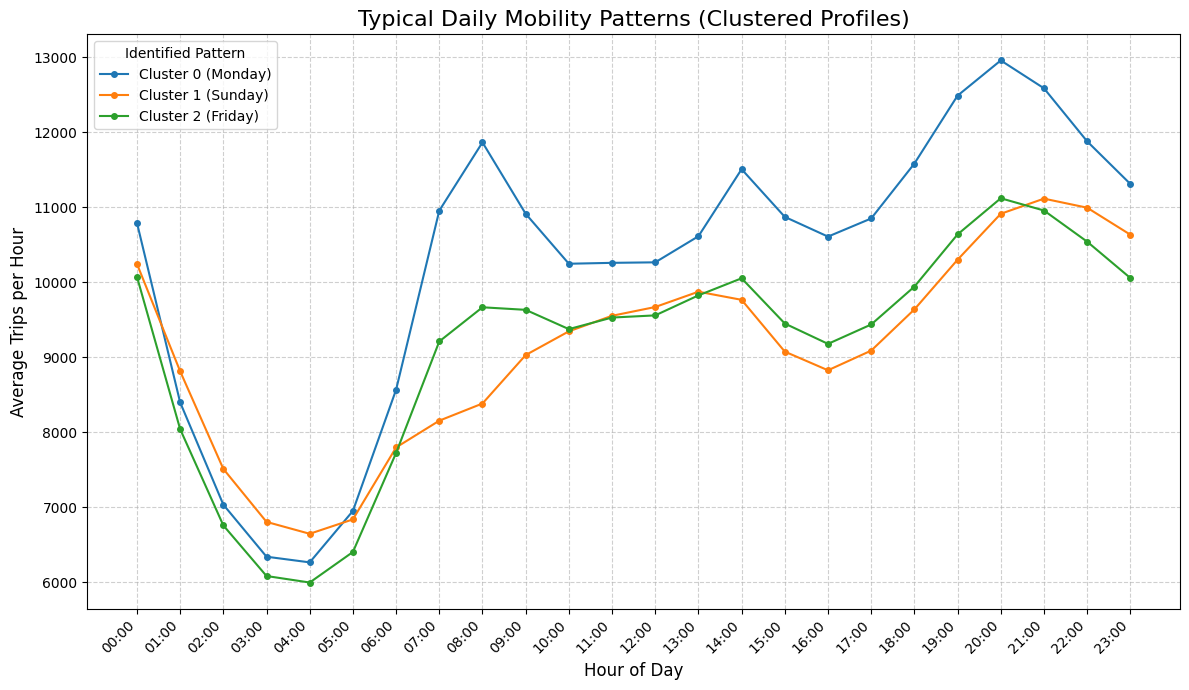

In [34]:
import matplotlib.pyplot as plt

# --- Query the data for plotting ---
print("Querying typical day demand data...")

# 1. RE-REGISTER the view 
# (Necessary because the previous cell unregistered it, but we need it to calculate labels)
con.register('view_dim_clusters', df_results)

# 2. Query: Calculate labels dynamically from the view and join with the Gold table
query = """
WITH cluster_labels AS (
    SELECT 
        cluster_id, 
        -- Calculate day name on the fly since we are using the view
        MODE(dayname(date)) as label
    FROM view_dim_clusters
    GROUP BY cluster_id
)
SELECT 
    t.hour,
    -- Create a readable label for the legend: "Cluster 0 (Sunday)"
    'Cluster ' || t.cluster_id || ' (' || l.label || ')' as pattern_name,
    t.avg_trips
FROM lakehouse.gold.typical_day_by_cluster t
JOIN cluster_labels l ON t.cluster_id = l.cluster_id
ORDER BY t.hour;
"""

demand_df = con.execute(query).df()

if demand_df.empty:
    print("ERROR: 'gold.typical_day_by_cluster' table is empty. No data to plot.")
else:
    # --- Prepare data for plotting ---
    print("Pivoting data for plotting...")
    # Pivot: Index=Hour, Columns=Pattern Name, Values=Average Trips
    pivot_df = demand_df.pivot(index='hour', columns='pattern_name', values='avg_trips')
    
    # --- Create the plot ---
    print("Generating plot with matplotlib...")
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the data
    pivot_df.plot(kind='line', ax=ax, marker='o', markersize=4)
    
    ax.set_title('Typical Daily Mobility Patterns (Clustered Profiles)', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Trips per Hour', fontsize=12)
    
    # Set x-ticks to be clear
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    ax.legend(title='Identified Pattern')
    
    # Ensure labels are not cut off
    plt.tight_layout()
    
    # Display the plot in the notebook
    plt.show()

# Optional: Clean up again if you want to keep memory clean
con.unregister('view_dim_clusters')

#### Business Question 2: Infrastructure Gaps

In [45]:
# Instalar y cargar la extensión espacial
con.execute("INSTALL 'spatial';")
con.execute("LOAD 'spatial';")

In [46]:
print("Creating Gold table 'gold_infrastructure_gaps'...")

# This query answers Business Question 2
gold_bq2_query = """--sql
CREATE OR REPLACE TABLE lakehouse.gold.gold_infrastructure_gaps AS

WITH od_pairs AS (
    SELECT
        origin_zone_id,
        destination_zone_id,
        SUM(trips) AS total_actual_trips
    FROM lakehouse.silver.fact_mobility
    GROUP BY 1, 2
),

unique_rent AS (
    SELECT 
        zone_id, 
        income_per_capita AS rent
    FROM lakehouse.silver.metric_ine_rent
    WHERE year = 2023
),

model_calculation AS (
    SELECT
        m.origin_zone_id AS org_zone_id,
        m.destination_zone_id AS dest_zone_id,
        p.population AS total_population,               -- P_i
        rent,                                           -- E_j
        m.total_actual_trips AS total_trips,            -- Actual trips
        
        -- Calculate distance (d_ij) in KM using the spatial extension
        -- We use GREATEST(0.5, ...) to avoid 0 distances (e.g., intra-zone trips)
        -- and thus prevent division by zero errors.
        GREATEST(
            0.5, -- Minimum distance of 0.5 km
            st_distance_spheroid(
                st_point(c_org.longitude, c_org.latitude), 
                st_point(c_dest.longitude, c_dest.latitude)
            ) / 1000 -- Convert meters (st_distance output) to KM
        ) AS geographic_distance_km
            
    FROM od_pairs AS m
    JOIN lakehouse.silver.metric_population AS p ON m.origin_zone_id = p.zone_id
    JOIN unique_rent ON m.destination_zone_id = unique_rent.zone_id
    JOIN lakehouse.silver.dim_coordinates as c_org ON m.origin_zone_id = c_org.zone_id
    JOIN lakehouse.silver.dim_coordinates as c_dest ON m.destination_zone_id = c_dest.zone_id

    
    -- Filter out bad data to prevent model errors
    WHERE p.population > 0 
      AND rent > 0
      AND c_org.latitude IS NOT NULL
      AND c_dest.latitude IS NOT NULL
      AND m.origin_zone_id != m.destination_zone_id -- Avoid intra-zone trips
)

-- Calculate final model and mismatch
SELECT
    org_zone_id,
    dest_zone_id,
    total_trips,
    total_population,
    rent,
    geographic_distance_km,
    
    -- Calculate Gravity Model T_ij = k * (P_i * E_j) / (d_ij^2)
    -- We assume k=1 for this Sprint 2
    (1.0 * (CAST(total_population AS DOUBLE) * CAST(rent AS DOUBLE))) / 
    (geographic_distance_km * geographic_distance_km) AS estimated_potential_trips, -- T_ij
        
    -- Calculate Mismatch Ratio 
    -- (Actual Trips / Estimated Trips)
    total_trips / NULLIF(estimated_potential_trips, 0) AS mismatch_ratio,
    CURRENT_TIMESTAMP as processed_at
    

FROM model_calculation;
"""

con.execute(gold_bq2_query)
print("✓ Table 'gold.gold_infrastructure_gaps' created.")

# --- Verification ---
print("\n--- Verification: Top 10 Zones with 'Mismatch' (potentially underserved) ---")
verification_bq2 = """--sql
    SELECT 
        org_zone_id,
        dest_zone_id,
        total_trips,
        estimated_potential_trips,
        mismatch_ratio
    FROM lakehouse.gold.gold_infrastructure_gaps
    WHERE total_trips > 10 -- Filter pairs with very few trips
    AND org_zone_id != dest_zone_id -- Avoid intra-zone trips
    ORDER BY mismatch_ratio ASC -- Order by lowest ratio (worst service)
    LIMIT 10;
"""
display(con.execute(verification_bq2).df())

Creating Gold table 'gold_infrastructure_gaps'...
✓ Table 'gold.gold_infrastructure_gaps' created.

--- Verification: Top 10 Zones with 'Mismatch' (potentially underserved) ---


,org_zone_id,dest_zone_id,total_trips,estimated_potential_trips,mismatch_ratio
0,2402,1131,20.0,175243.733577,0.000114
1,499,347,40.0,287782.906528,0.000139
2,383,2124,22.0,121824.542840,0.000181
3,1572,1005,11.0,57512.346728,0.000191
4,2568,609,70.0,318275.368929,0.000220
5,287,459,20.0,87031.563151,0.000230
6,322,444,25.0,89273.112806,0.000280
7,2439,2473,25.0,80146.542722,0.000312
8,1410,1028,22.0,67713.891189,0.000325
9,2071,2040,15.0,45971.249307,0.000326


In [37]:
query="""SELECT zone_id, zone_name FROM lakehouse.silver.dim_zones WHERE zone_id IN(2402, 1131);"""
con.execute(query).df()

,zone_id,zone_name
0,1131,Grañén agregacion de municipios
1,2402,València


# Close connection

In [38]:
print("--- 📜 Transaction Log (Snapshots) ---")
# This shows the ID, Timestamp, and usually the schema/table changed
snapshots_df = con.execute("SELECT * FROM lakehouse.snapshots() ").df()
print(snapshots_df)

--- 📜 Transaction Log (Snapshots) ---
    snapshot_id                    snapshot_time  schema_version  \
0             0 2025-12-04 11:57:27.743144+01:00               0   
1             1 2025-12-04 11:57:28.100414+01:00               1   
2             2 2025-12-04 11:57:28.173328+01:00               2   
3             3 2025-12-04 11:57:28.249788+01:00               3   
4             4 2025-12-04 12:00:09.594325+01:00               4   
..          ...                              ...             ...   
64           64 2025-12-04 12:04:43.247617+01:00              17   
65           65 2025-12-04 12:04:44.139939+01:00              17   
66           66 2025-12-04 12:05:15.778812+01:00              18   
67           67 2025-12-04 12:06:05.032050+01:00              19   
68           68 2025-12-04 12:06:10.232958+01:00              20   

                                                                                  changes  \
0                                                   

In [47]:
con.close()